In [15]:
# Please use current (work) folder to store your data and models
import os
import sys
import os
import sys
import re
import base64
import json
from io import BytesIO
from keras.preprocessing import image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

sys.path.append('../')

from modules import json_parser
from modules import Client

client = Client('fackAPI')
run = client.run
train = client.train
predict = client.predict

In [16]:
test_img_path = './fbb.jpg'

In [17]:
rgb_image = image.load_img(test_img_path)

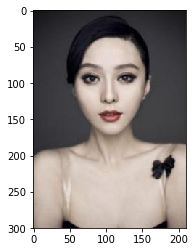

In [18]:
plt.imshow(rgb_image)

In [5]:
gray_image =  image.load_img(test_img_path, True )

In [6]:
rgb_image = image.img_to_array(rgb_image)
gray_image = image.img_to_array(gray_image)


In [8]:
gender_classifier_conf = {'rgb_image':rgb_image,'gray_image':gray_image}

result = run('zhaofengli/new_gender_classifier/0.0.1', gender_classifier_conf)

In [9]:
result

[{'gender': 'woman', 'location': array([ 41,  43, 130, 130], dtype=int32)}]

In [14]:
data_path = './images'
feed ={'data_path':data_path,'model_save_path':'mymodel.h5','weight_save_path':'myweight.hdf5','epochs':2,'log_dir':'logs/0426'}
res = train('zhaofengli/new_face_feature/0.0.1',feed)

myweight.hdf5
Train on 1823 samples, validate on 229 samples
Epoch 1/2
1823/1823 [==============================] - 25s 14ms/step - loss: 2.5184 - acc: 0.1344 - val_loss: 3.5280 - val_acc: 0.1048

Epoch 00001: val_loss improved from inf to 3.52802, saving model to myweight.hdf5
Epoch 2/2
1823/1823 [==============================] - 25s 14ms/step - loss: 2.3556 - acc: 0.2052 - val_loss: 2.2960 - val_acc: 0.2052

Epoch 00002: val_loss improved from 3.52802 to 2.29596, saving model to myweight.hdf5


In [ ]:
conf = '{"model_path":"1","weight_path":"1","imgs":"1"}'
conf = json_parser(conf)
print(conf)

In [ ]:
result = predict('zhaofengli/face_feature_module', conf)

In [12]:
boy_path_list = os.listdir("boy")
boy_path_list = ["boy/"+p for p in boy_path_list]
img_list = [image.img_to_array(image.load_img(p, target_size=(224, 224))) for p in boy_path_list]
feed ={'imgs':img_list,'model_path':'mymodel.h5','weight_path':'myweight.hdf5'}
res = predict('zhaofengli/face_feature',feed)

../modules/zhaofengli/face_feature/src/main.py:128: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  output=self.model.get_layer('fc1').output)


In [14]:
def face_distance(face_encodings, face_to_compare):
    if len(face_encodings) == 0:
        return np.empty((0))
    return np.linalg.norm(face_encodings - face_to_compare, axis=1)

In [15]:
res = [i[0,:] for i in res]
dis = face_distance(res,res[-1])

In [16]:
dis

array([14.6047  , 17.36139 , 22.955997, 14.441742, 10.215594, 18.37923 ,
       14.65933 , 18.964285, 21.436018, 18.223269,  0.      ],
      dtype=float32)

In [17]:
def base64_to_image(base64_str, grayscale, target_size):
    base64_data = re.sub('^data:image/.+;base64,', '', base64_str)
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    img = image.load_img(image_data, grayscale, target_size)
    return image.img_to_array(img)

In [18]:
def image_to_base64(img):
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue())
    return img_str.decode("utf-8")

In [19]:
fbb = image.load_img('fbb.jpg')
base64img = image_to_base64(fbb)

conf = {'img':base64img}
input_img = conf['img']

rgb_image = base64_to_image(input_img,False,target_size=(224, 224))
gray_image = base64_to_image(input_img,True,target_size=(224, 224))

gender_classifier_conf = {'rgb_image':rgb_image,'gray_image':gray_image}
result = run('zhaofengli/gender_classifier_module', gender_classifier_conf)


if len(result)>0:
    gender = result[0]['gender']
else:
    gender = 'man'
if gender == 'man':
    girl_path_list = os.listdir("girl")
    girl_path_list = ["girl/"+p for p in girl_path_list]
    img_list = [image.img_to_array(image.load_img(p, target_size=(224, 224))) for p in girl_path_list]
else:
    boy_path_list = os.listdir("boy")
    boy_path_list = ["boy/"+p for p in boy_path_list]
    img_list = [image.img_to_array(image.load_img(p, target_size=(224, 224))) for p in boy_path_list]
img_list.append(rgb_image)

feed ={'imgs':img_list,'model_path':'mymodel.h5','weight_path':'myweight.hdf5'}

res = predict('zhaofengli/face_feature_module',feed)

res = [i[0,:] for i in res]
dis = face_distance(res[0:-1],res[-1])
index = dis.argmin()
base64_str = image_to_base64(image.array_to_img(img_list[index]))
print(json.dumps({"fql": base64_str}))

../modules/zhaofengli/face_feature_module/src/main.py:128: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  output=self.model.get_layer('fc1').output)


{"fql": "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCADgAOADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDwqMVr6bbmSReO9ZcKg8k/hXV+HoA8gOM+9KT0Mo6s6PTrUJGDxW3AMe9VYE+UCrsYwB0rE6krF+DqK0YTzWZD2xWpApx0poTL8PUVpRHgVn20ZOOK1EiIAODVCLMTcVZQ9OlU0yKso+Mc0AXU/nUwAYYHNVEkGAe